Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely.geometry import Point

import plotly.express as px
import plotly.graph_objects as go

import ipywidgets as widgets

Set mapbox token

In [2]:
mapbox_access_token = open('token.mapbox_token').read()
px.set_mapbox_access_token(mapbox_access_token)

Read csv data, create geometry data with correct projection

In [3]:
df = pd.read_csv('Anabasis.csv', keep_default_na=False)
df['geometry'] = gpd.points_from_xy(df['longitude'], df['latitude'])

gdf = gpd.GeoDataFrame(df)
gdf.set_crs(epsg=4326, allow_override=True, inplace=True)

gdf.head()

latitude  longitude  start_day  end_day event_type event_name  \
0  37.941111  27.341944          0        0       city    Ephesus   
1  38.488333  28.040278          7       30       city     Sardes   
2  36.494167  36.024167        150      157       city  Myriandos   
3  33.321579  44.074388        213      213     battle     Cunaxa   

                                   event_description            bibliography  \
0  Xenophon departs from Ephesus to join the expe...                           
1  Xenophon arrives in Sardes where Cyrus is gath...                           
2  Cyrus' forces arrive at Myriandos, at the bord...                   1.4.6   
3  The Hellenes fight alongside Cyrus and emerge ...  1.7.20; 1.10.1-1.10.18   

  troop_count                   geometry  
0              POINT (27.34194 37.94111)  
1              POINT (28.04028 38.48833)  
2              POINT (36.02417 36.49417)  
3              POINT (44.07439 33.32158)

Clean up troop count

In [4]:
def clean_troop_count(troop_count):
    if troop_count == '':
        return 0
    
    return int(troop_count)

gdf['troop_count'] = gdf.apply(lambda row: clean_troop_count(row['troop_count']), axis = 1)

gdf.head()

latitude  longitude  start_day  end_day event_type event_name  \
0  37.941111  27.341944          0        0       city    Ephesus   
1  38.488333  28.040278          7       30       city     Sardes   
2  36.494167  36.024167        150      157       city  Myriandos   
3  33.321579  44.074388        213      213     battle     Cunaxa   

                                   event_description            bibliography  \
0  Xenophon departs from Ephesus to join the expe...                           
1  Xenophon arrives in Sardes where Cyrus is gath...                           
2  Cyrus' forces arrive at Myriandos, at the bord...                   1.4.6   
3  The Hellenes fight alongside Cyrus and emerge ...  1.7.20; 1.10.1-1.10.18   

   troop_count                   geometry  
0            0  POINT (27.34194 37.94111)  
1            0  POINT (28.04028 38.48833)  
2            0  POINT (36.02417 36.49417)  
3            0  POINT (44.07439 33.32158)

Start date configuration

In [5]:
start_date = np.datetime64('-401-04-20T00:00:00')

def generate_date(date):
    return start_date + np.timedelta64(date, 'D')

gdf['start_date'] = gdf.apply(lambda row: generate_date(row['start_day']), axis = 1)
gdf['end_date'] = gdf.apply(lambda row: generate_date(row['end_day']), axis = 1)

gdf.head()

latitude  longitude  start_day  end_day event_type event_name  \
0  37.941111  27.341944          0        0       city    Ephesus   
1  38.488333  28.040278          7       30       city     Sardes   
2  36.494167  36.024167        150      157       city  Myriandos   
3  33.321579  44.074388        213      213     battle     Cunaxa   

                                   event_description            bibliography  \
0  Xenophon departs from Ephesus to join the expe...                           
1  Xenophon arrives in Sardes where Cyrus is gath...                           
2  Cyrus' forces arrive at Myriandos, at the bord...                   1.4.6   
3  The Hellenes fight alongside Cyrus and emerge ...  1.7.20; 1.10.1-1.10.18   

   troop_count                   geometry           start_date  \
0            0  POINT (27.34194 37.94111)  -401-04-20T00:00:00   
1            0  POINT (28.04028 38.48833)  -401-04-27T00:00:00   
2            0  POINT (36.02417 36.49417)  -401-09-17T00:00:00   
3            0  POINT (44.07439 33.32158)  -401-11-19T00:00:00   

              end_date  
0  -401-04-20T00:00:00  
1  -401-05-20T00:00:00  
2  -401-09-24T00:00:00  
3  -401-11-19T00:00:00

Pretty print for dates

In [6]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def prettifyDate(date):
    dateString = np.datetime_as_string(date, unit='D')
    
    isBC = dateString[0] == '-'
    if isBC:
        dateString = dateString[1:]
    
    parts = dateString.split('-')
    
    result = parts[2] + " " + months[int(parts[1]) - 1] + " " + parts[0]
    if isBC:
        result += " BC"
    
    return result

Create the marker symbols

In [7]:
marker_lookup = {
    "city": "castle",
    "battle": "cross"
}
    
def get_marker_symbol(event_type):
    return marker_lookup.get(event_type)

gdf['marker'] = gdf.apply(lambda row: get_marker_symbol(row['event_type']), axis = 1)

gdf.head()

latitude  longitude  start_day  end_day event_type event_name  \
0  37.941111  27.341944          0        0       city    Ephesus   
1  38.488333  28.040278          7       30       city     Sardes   
2  36.494167  36.024167        150      157       city  Myriandos   
3  33.321579  44.074388        213      213     battle     Cunaxa   

                                   event_description            bibliography  \
0  Xenophon departs from Ephesus to join the expe...                           
1  Xenophon arrives in Sardes where Cyrus is gath...                           
2  Cyrus' forces arrive at Myriandos, at the bord...                   1.4.6   
3  The Hellenes fight alongside Cyrus and emerge ...  1.7.20; 1.10.1-1.10.18   

   troop_count                   geometry           start_date  \
0            0  POINT (27.34194 37.94111)  -401-04-20T00:00:00   
1            0  POINT (28.04028 38.48833)  -401-04-27T00:00:00   
2            0  POINT (36.02417 36.49417)  -401-09-17T00:00:00   
3            0  POINT (44.07439 33.32158)  -401-11-19T00:00:00   

              end_date  marker  
0  -401-04-20T00:00:00  castle  
1  -401-05-20T00:00:00  castle  
2  -401-09-24T00:00:00  castle  
3  -401-11-19T00:00:00   cross

Create base plot

In [8]:
fig = go.Figure(
    go.Scattermapbox(
        lat=gdf.geometry.y,
        lon=gdf.geometry.x,
        mode='markers+lines',
        marker_symbol=gdf.marker,
        marker_size=15,
        customdata=np.stack((gdf['event_name'], gdf['start_date'].apply(prettifyDate), gdf['end_date'].apply(prettifyDate), gdf['event_description'], gdf['bibliography']), axis=-1),
        hovertemplate = '<b>%{customdata[0]}</b><br><br>' +
            'Start: %{customdata[1]}<br>'+
            'End: %{customdata[2]}<br>'+
            '%{customdata[3]}<br>'+
            'Bibliography: %{customdata[4]}'+
            '<extra></extra>'
    )
)

print("Created base plot")

Created base plot


Create plot layout, configure mapbox rendering

In [9]:
extents_latitude =[gdf["latitude"].min(), gdf["latitude"].max()]
extents_longitude =[gdf["longitude"].min(), gdf["longitude"].max()]
max_bound = max(abs(extents_latitude[0]-extents_latitude[1]), abs(extents_longitude[0]-extents_longitude[1])) * 111
zoom = 12.5 - np.log(max_bound)

fig.update_layout(
    title='Anabasis - March of the Ten Thousand',
    autosize=False,
    width=1000,
    height=750,
    hovermode='closest',
    mapbox=dict(
        accesstoken = mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=extents_latitude[0] + (extents_latitude[1] - extents_latitude[0]) / 2,
            lon=extents_longitude[0] + (extents_longitude[1] - extents_longitude[0]) / 2
        ),
        pitch=0,
        zoom=zoom,
        style='mapbox://styles/wolololf/ckjcyusqlks2a19qts3en5dnf'
    ))

print("Configured layout")

Configured layout


Fill in the frames by day. We will then step through these using sliders.

In [10]:
days = range(gdf['end_day'].max() + 1)

frames = []

for day in days:
    filtered_gdf = gdf[gdf['start_day'] <= day]

    idx = filtered_gdf['start_day'].idxmax()
    previous_day = filtered_gdf.iloc[idx]

    if previous_day['end_day'] < day:
        next_day = gdf.iloc[idx+1]

        date = generate_date(day)

        departure_day = previous_day['end_day']
        arrival_day = next_day['start_day']
        factor = (day - departure_day) / (arrival_day - departure_day)

        lat = previous_day['latitude'] + (next_day['latitude'] - previous_day['latitude']) * factor
        lon = previous_day['longitude'] + (next_day['longitude'] - previous_day['longitude']) * factor

        interpolated = {
            'event_name': "On the road",
            'event_description': "",
            'bibliography': "",
            'start_day': day,
            'start_date': date,
            'end_day': day,
            'end_date': date,
            'troop_count': previous_day['troop_count'] + (next_day['troop_count'] - previous_day['troop_count']) * factor,
            'latitude': lat,
            'longitude': lon,
            'geometry': Point(lon, lat),
            'marker': ''
        }

        filtered_gdf = filtered_gdf.append(interpolated, ignore_index=True)
    
    frame = go.Frame(
        data=[
            go.Scattermapbox(
            lat=filtered_gdf.geometry.y,
            lon=filtered_gdf.geometry.x,
            marker_symbol=filtered_gdf.marker,
            customdata=np.stack(
                (
                    filtered_gdf['event_name'],
                    filtered_gdf['start_date'].apply(prettifyDate),
                    filtered_gdf['end_date'].apply(prettifyDate),
                    filtered_gdf['event_description'],
                    filtered_gdf['bibliography']),
                    axis=-1
                )
            )
        ], 
        traces= [0],
        name=day
    )
    
    frames.append(frame)

fig.update(frames=frames)

print("Created frames")

Created frames


Define slider visuals

In [11]:
transition = dict(
    duration=100,
    easing = "cubic-in-out"
)
frame_anim = dict(
    duration=100,
    redraw=True
)

sliders = dict(steps=[],
    active=0,
    currentvalue=dict(
        font=dict(size=12), 
        prefix='Date: ', 
        visible=True, 
        xanchor= 'left'
    ),
    transition=transition,
    x=0.15,
    y=0,
    len=0.85,
    xanchor="left",
    yanchor="top"
)

for day in days:
    slider_step = dict(
        method='animate',
        value=day,
        label=prettifyDate(generate_date(day)),
        args=[
            [day],
            dict(
                mode='immediate',
                frame=frame_anim,
                transition=transition
            )
        ]
    )
    
    sliders["steps"].append(slider_step)

fig.update_layout(sliders=[sliders])

print("Created sliders")

Created sliders


Define play and pause buttons

In [12]:
updatemenus = dict(
    type='buttons',
    showactive=True,
    x=0,
    y=-0.05,
    xanchor = "left",
    yanchor = "top",
    direction = "left",
    buttons=[
        dict(
            label='Play',
            method='animate',
            args=[
                None, 
                dict(
                    frame=frame_anim,
                    transition=transition,
                    fromcurrent=True,
                    mode='immediate'
                )
            ]
        ),
        dict(
            label='Pause',
            method='animate',
            args=[
                [None], 
                dict(
                    frame=frame_anim,
                    transition=transition,
                    mode='immediate'
                )
            ]
        )
    ]
)

fig.update_layout(updatemenus=[updatemenus])

print("Created buttons")

Created buttons


Put it all together and render the plot

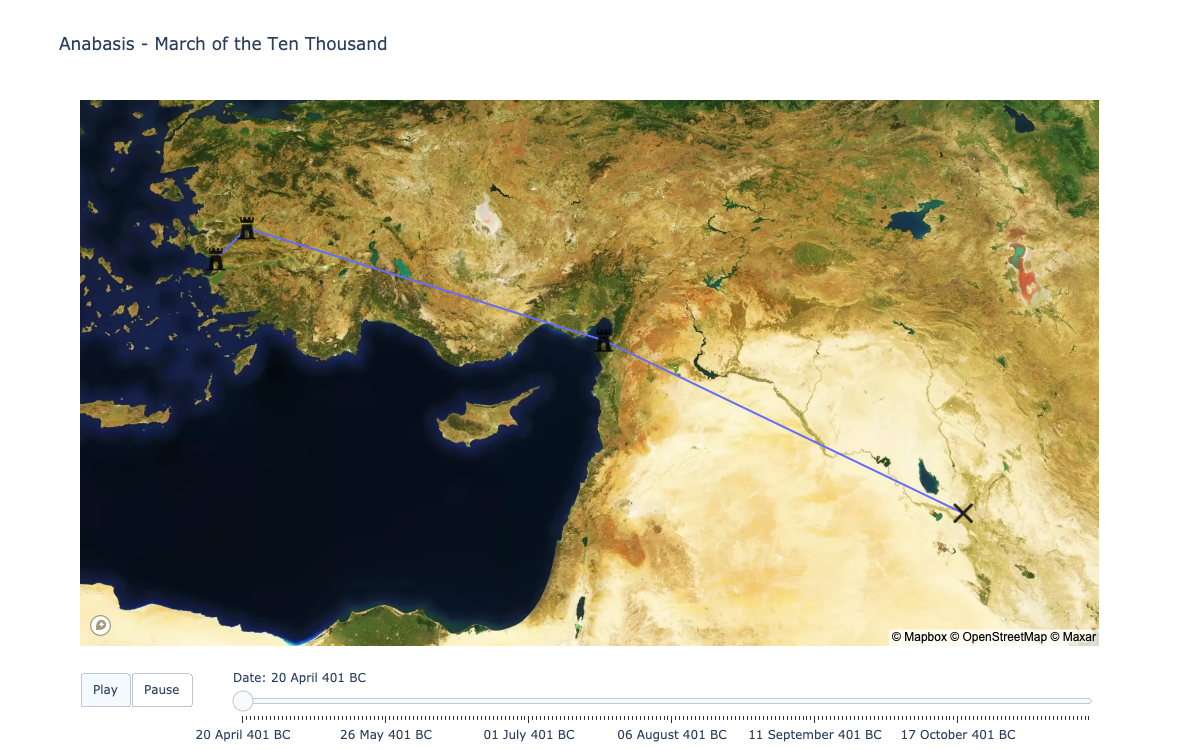

In [13]:
fig.show()